# 1. Setup

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
language = 'Punjabi'
data_dir = f'Data/{language}'
train_dir = f'{data_dir}/Train'
val_dir = f'{data_dir}/Val'
test_dir = f'{data_dir}/Test'
test_dir_v2 = f'Data/{language}-V2-Test'

In [3]:
character_df_fp = f'Data/Characters/Characters-{language}.csv'

In [4]:
cpu_count = 16 #os.cpu_count()
print(cpu_count)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

16
cuda


# 2. Define character class

In [5]:
character_df = pd.read_csv(character_df_fp)
print(character_df.shape)
character_df.head()

(696, 3)


,Character,Consonant,Glyph
0,ਅ,-,-
1,ਆ,-,ਾ
2,ਇ,-,ਿ
3,ਈ,-,ੀ
4,ਉ,-,ੁ


In [6]:
#character_df[character_df['Consonant']=="-"]

In [7]:
characters = set()
for character in character_df['Character'].values:
    characters.update(list(character))
characters = ["-"] + sorted(list(characters))
print(len(characters))
print(characters)

67
['-', 'ਁ', 'ਃ', 'ਅ', 'ਆ', 'ਇ', 'ਈ', 'ਉ', 'ਊ', 'ਏ', 'ਐ', 'ਓ', 'ਔ', 'ਕ', 'ਖ', 'ਗ', 'ਘ', 'ਙ', 'ਚ', 'ਛ', 'ਜ', 'ਝ', 'ਞ', 'ਟ', 'ਠ', 'ਡ', 'ਢ', 'ਣ', 'ਤ', 'ਥ', 'ਦ', 'ਧ', 'ਨ', 'ਪ', 'ਫ', 'ਬ', 'ਭ', 'ਮ', 'ਯ', 'ਰ', 'ਲ', 'ਲ਼', 'ਵ', 'ਸ਼', 'ਸ', 'ਹ', '਼', 'ਾ', 'ਿ', 'ੀ', 'ੁ', 'ੂ', 'ੇ', 'ੈ', 'ੋ', 'ੌ', '੍', 'ੑ', 'ਖ਼', 'ਗ਼', 'ਜ਼', 'ੜ', 'ਫ਼', 'ੰ', 'ੱ', 'ੲ', 'ੳ']


In [8]:
idx2char = {k:v for k,v in enumerate(characters)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

{0: '-', 1: 'ਁ', 2: 'ਃ', 3: 'ਅ', 4: 'ਆ', 5: 'ਇ', 6: 'ਈ', 7: 'ਉ', 8: 'ਊ', 9: 'ਏ', 10: 'ਐ', 11: 'ਓ', 12: 'ਔ', 13: 'ਕ', 14: 'ਖ', 15: 'ਗ', 16: 'ਘ', 17: 'ਙ', 18: 'ਚ', 19: 'ਛ', 20: 'ਜ', 21: 'ਝ', 22: 'ਞ', 23: 'ਟ', 24: 'ਠ', 25: 'ਡ', 26: 'ਢ', 27: 'ਣ', 28: 'ਤ', 29: 'ਥ', 30: 'ਦ', 31: 'ਧ', 32: 'ਨ', 33: 'ਪ', 34: 'ਫ', 35: 'ਬ', 36: 'ਭ', 37: 'ਮ', 38: 'ਯ', 39: 'ਰ', 40: 'ਲ', 41: 'ਲ਼', 42: 'ਵ', 43: 'ਸ਼', 44: 'ਸ', 45: 'ਹ', 46: '਼', 47: 'ਾ', 48: 'ਿ', 49: 'ੀ', 50: 'ੁ', 51: 'ੂ', 52: 'ੇ', 53: 'ੈ', 54: 'ੋ', 55: 'ੌ', 56: '੍', 57: 'ੑ', 58: 'ਖ਼', 59: 'ਗ਼', 60: 'ਜ਼', 61: 'ੜ', 62: 'ਫ਼', 63: 'ੰ', 64: 'ੱ', 65: 'ੲ', 66: 'ੳ'}
{'-': 0, 'ਁ': 1, 'ਃ': 2, 'ਅ': 3, 'ਆ': 4, 'ਇ': 5, 'ਈ': 6, 'ਉ': 7, 'ਊ': 8, 'ਏ': 9, 'ਐ': 10, 'ਓ': 11, 'ਔ': 12, 'ਕ': 13, 'ਖ': 14, 'ਗ': 15, 'ਘ': 16, 'ਙ': 17, 'ਚ': 18, 'ਛ': 19, 'ਜ': 20, 'ਝ': 21, 'ਞ': 22, 'ਟ': 23, 'ਠ': 24, 'ਡ': 25, 'ਢ': 26, 'ਣ': 27, 'ਤ': 28, 'ਥ': 29, 'ਦ': 30, 'ਧ': 31, 'ਨ': 32, 'ਪ': 33, 'ਫ': 34, 'ਬ': 35, 'ਭ': 36, 'ਮ': 37, 'ਯ': 38, 'ਰ': 39, 'ਲ': 40, 'ਲ਼': 41, 'ਵ': 42, 'ਸ਼': 43, 'ਸ': 44, 'ਹ': 45, '

# 3. Define data loader

In [9]:
class IndianSceneTextDataset(Dataset):
    
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.image_fns = os.listdir(data_dir)
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split("_")[0][:13]
        return image, text, image_fn
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [10]:
def tokenize(text):

    text_tokens = list(text)
    
    return text_tokens

# 4. Define model

In [11]:
resnet = resnet18(pretrained=True)
#print(resnet)

In [12]:
for p in resnet.parameters():
    p.requires_grad = False

In [13]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dp1 = nn.Dropout(p=0.5)
        self.dp2 = nn.Dropout(p=0.5)
        self.dp3 = nn.Dropout(p=0.5)
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            num_layers=2,
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True,
                            num_layers=1, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        batch = self.dp1(batch)
        # print(batch.size())# torch.Size([-1, 256, 4, 13])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 13, 256, 4])
        
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 13, 1024])
        
        batch = self.linear1(batch)
        batch = self.dp2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn2(batch)
        batch = self.dp3(batch)
        # print(batch.size()) # torch.Size([-1, 13, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 375])
        
        batch = batch.permute(1, 0, 2) # [T, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([13, -1, 375])
        
        return batch

# 5. Make predictions

In [14]:
batch_size = 64
rnn_hidden_size = 256

In [15]:
trainset = IndianSceneTextDataset(train_dir) 
valset = IndianSceneTextDataset(val_dir)
testset = IndianSceneTextDataset(test_dir)
testset_v2 = IndianSceneTextDataset(test_dir_v2)

train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
val_loader = DataLoader(valset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
test_loader_v2 = DataLoader(testset_v2, batch_size=batch_size, num_workers=cpu_count, shuffle=False)

In [16]:
model_path = f'Models/{language}-Unicode-e40.pth'

crnn = CRNN(len(char2idx), rnn_hidden_size=rnn_hidden_size)
crnn.load_state_dict(torch.load(model_path))
crnn = crnn.to(device)
crnn.eval()

CRNN(
  (dp1): Dropout(p=0.5, inplace=False)
  (dp2): Dropout(p=0.5, inplace=False)
  (dp3): Dropout(p=0.5, inplace=False)
  (cnn_p1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [17]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [18]:
def make_predictions(data_loader):
    result = pd.DataFrame(columns=['image_fn', 'actual', 'prediction'])
    with torch.no_grad():
        for image_batch, text_batch, image_fn_batch in tqdm(data_loader, leave=False):
            text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
            text_batch_pred = decode_predictions(text_batch_logits.cpu())
            #print(text_batch, text_batch_pred)
            df = pd.DataFrame(columns=['actual', 'prediction'])
            df['image_fn'] = image_fn_batch
            df['actual'] = text_batch
            df['prediction'] = text_batch_pred
            result = pd.concat([result, df])
    result = result.reset_index(drop=True)
    return result

In [19]:
train_result = make_predictions(train_loader)
val_result = make_predictions(val_loader)
test_result = make_predictions(test_loader)
test_result_v2 = make_predictions(test_loader_v2)

In [20]:
print(train_result.shape)
print(val_result.shape)
print(test_result.shape)
print(test_result_v2.shape)
train_result.head()

(399989, 3)
(5000, 3)
(5000, 3)
(2577, 3)


,image_fn,actual,prediction
0,ਦਫ਼ਤਰ_28_3867_1.jpg,ਦਫ਼ਤਰ,ਦ-----ਫ਼-ਤ-ਰ-
1,ਤਰਾਰ_7_3541_1.jpg,ਤਰਾਰ,ਤ------ਰਾਾ-ਰ-
2,ਸੰਪਤ_8_4276_1.jpg,ਸੰਪਤ,ਗ----------ਤ-
3,ਉਸਦੀ_2_792_2.jpg,ਉਸਦੀ,ਉ-----ਸ----ਦੀ
4,ਵਾਲ_13_1756_0.jpg,ਵਾਲ,ਵ-----ਾ----ਲ-


In [21]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [22]:
train_result['prediction_corrected'] = train_result['prediction'].apply(correct_prediction)
val_result['prediction_corrected'] = val_result['prediction'].apply(correct_prediction)
test_result['prediction_corrected'] = test_result['prediction'].apply(correct_prediction)
test_result_v2['prediction_corrected'] = test_result_v2['prediction'].apply(correct_prediction)

In [23]:
train_result['actual_length'] = train_result['actual'].apply(len)
val_result['actual_length'] = val_result['actual'].apply(len)
test_result['actual_length'] = test_result['actual'].apply(len)
test_result_v2['actual_length'] = test_result_v2['actual'].apply(len)

train_result['prediction_length'] = train_result['prediction_corrected'].apply(len)
val_result['prediction_length'] = val_result['prediction_corrected'].apply(len)
test_result['prediction_length'] = test_result['prediction_corrected'].apply(len)
test_result_v2['prediction_length'] = test_result_v2['prediction_corrected'].apply(len)

In [24]:
def levenshteinDistance(row):
    
    s1 = row['actual']
    s2 = row['prediction_corrected']
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [25]:
train_result['edit_distance'] = train_result.progress_apply(levenshteinDistance, axis=1)
val_result['edit_distance'] = val_result.apply(levenshteinDistance, axis=1)
test_result['edit_distance'] = test_result.apply(levenshteinDistance, axis=1)
test_result_v2['edit_distance'] = test_result_v2.apply(levenshteinDistance, axis=1)

# 6. Evaluate the model

In [26]:
train_accuracy = accuracy_score(train_result['actual'], train_result['prediction_corrected'])
val_accuracy = accuracy_score(val_result['actual'], val_result['prediction_corrected'])
test_accuracy = accuracy_score(test_result['actual'], test_result['prediction_corrected'])
test_accuracy_v2 = accuracy_score(test_result_v2['actual'], test_result_v2['prediction_corrected'])
print(train_accuracy, val_accuracy, test_accuracy, test_accuracy_v2)

0.780186455127516 0.6584 0.7338 0.916569654637175


In [28]:
accuracy_df = []
for max_edit_distance in range(4+1):
    train_accuracy = (train_result['edit_distance'] <= max_edit_distance).sum() / len(train_result)
    val_accuracy = (val_result['edit_distance'] <= max_edit_distance).sum() / len(val_result)
    test_accuracy = (test_result['edit_distance'] <= max_edit_distance).sum() / len(test_result)
    test_accuracy_v2 = (test_result_v2['edit_distance'] <= max_edit_distance).sum() / len(test_result_v2)
    accuracy_df.append([max_edit_distance, train_accuracy, val_accuracy, test_accuracy, test_accuracy_v2])
columns=['Max-Edit-Distance', 'Train-Accuracy', 'Val-Accuracy', 'Test-Accuracy', 'V2-Test-Accuracy']
accuracy_df = pd.DataFrame(accuracy_df, columns=columns)
accuracy_df.to_csv(f'Results/{language}.csv', index=False)
accuracy_df

,Max-Edit-Distance,Train-Accuracy,Val-Accuracy,Test-Accuracy,V2-Test-Accuracy
0,0,0.780186,0.6584,0.7338,0.916570
1,1,0.859134,0.7510,0.8224,0.972837
2,2,0.910375,0.8308,0.8894,0.992627
3,3,0.955221,0.9106,0.9404,0.996896
4,4,0.978642,0.9550,0.9748,0.998448


In [29]:
test_result['edit_distance'].describe()

count    5000.000000
mean        0.657800
std         1.336659
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        10.000000
Name: edit_distance, dtype: float64

In [30]:
def visualize_misclassifications(split='Train', num_samples=20, max_edit_distance=1):
    
    if split == 'Train':
        result = train_result
    elif split == 'Val':
        result = val_result
    elif split == 'Test':
        result = test_result
    elif split == "Test-V2":
        result = test_result_v2
        
    mask = result['edit_distance'] >= max_edit_distance
    result = result[mask].sample(n = num_samples)
    for row_id, row in result.iterrows():
        info = 'Actual:', row['actual'], 'Prediction:', row['prediction'], \
              'Prediction Corrected:', row['prediction_corrected']
        print(info)
        
        if split == 'Test-V2':
            image_fp = f'Data/{language}-V2-Test/{row["image_fn"]}'
        else:
            image_fp = f'Data/{language}/{split}/{row["image_fn"]}'
        
        plt.imshow(Image.open(image_fp))
        plt.axis(False)
        plt.show()
    

In [31]:
#visualize_misclassifications('Train')

In [32]:
#visualize_misclassifications('Val')

('Actual:', 'ਉਰਝਿ', 'Prediction:', 'ਉ------ਰ---ਕਿ', 'Prediction Corrected:', 'ਉਰਕਿ')


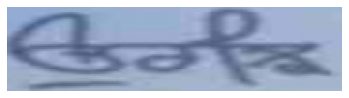

('Actual:', 'ਦਾਊਦ', 'Prediction:', 'ਜ------ਊ---ਦ-', 'Prediction Corrected:', 'ਜਊਦ')


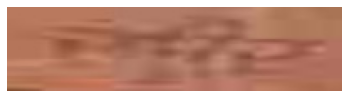

('Actual:', 'ਹਨ', 'Prediction:', 'ਪ----------ਨ-', 'Prediction Corrected:', 'ਪਨ')


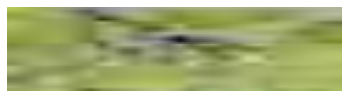

('Actual:', 'ਯਥਾਰਥਵਾਦ', 'Prediction:', 'ਯ---ਵ਼ਰਥਵਵਾਦ-', 'Prediction Corrected:', 'ਯਵ਼ਰਥਵਾਦ')


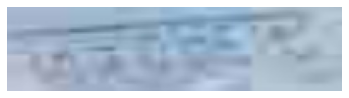

('Actual:', 'ਪਰਿਆ', 'Prediction:', 'ਪਉ---------ੜੀ', 'Prediction Corrected:', 'ਪਉੜੀ')


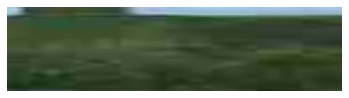

('Actual:', 'ਦਿਓ', 'Prediction:', 'ਜ----ਿਿ----ਓ-', 'Prediction Corrected:', 'ਜਿਓ')


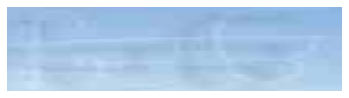

('Actual:', 'ਐਡਵਰਡ', 'Prediction:', 'ਐ---ਡ-ਵਵ-ਰ-ਤ-', 'Prediction Corrected:', 'ਐਡਵਰਤ')


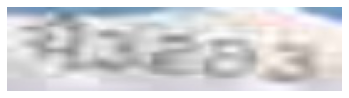

('Actual:', 'ਫੋਕਸ', 'Prediction:', 'ਫ---ੌ--ਕ---ਮ-', 'Prediction Corrected:', 'ਫੌਕਮ')


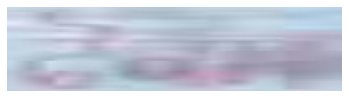

('Actual:', 'ਸ਼ਲਭ', 'Prediction:', 'ਸ------ਨ---ਦ-', 'Prediction Corrected:', 'ਸਨਦ')


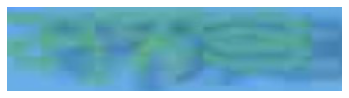

('Actual:', 'ਪਉੜੀ', 'Prediction:', 'ਪ----------ੜੀ', 'Prediction Corrected:', 'ਪੜੀ')


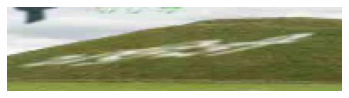

('Actual:', 'ਰਾਮ', 'Prediction:', 'ਹ----------ਰ-', 'Prediction Corrected:', 'ਹਰ')


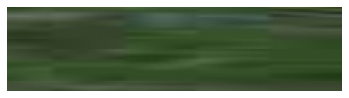

('Actual:', 'ਦਾਸ', 'Prediction:', 'ਲ----------ਮਾ', 'Prediction Corrected:', 'ਲਮਾ')


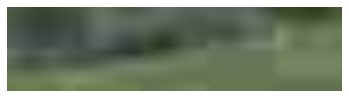

('Actual:', 'ਦਮ', 'Prediction:', 'ਤ----------ਮ-', 'Prediction Corrected:', 'ਤਮ')


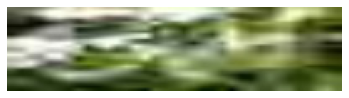

('Actual:', 'ਬਰ', 'Prediction:', 'ਜ----------ਹ-', 'Prediction Corrected:', 'ਜਹ')


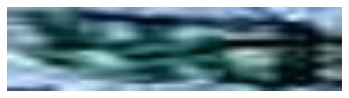

('Actual:', 'ਬਾਗੇਸਵਰ', 'Prediction:', 'ਬ--ਾਗ-ੀਸ-ਵਵਰ-', 'Prediction Corrected:', 'ਬਾਗੀਸਵਰ')


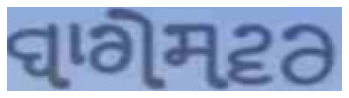

('Actual:', 'ਅਪਰਾਧੀ', 'Prediction:', 'ਕ----------ਰ-', 'Prediction Corrected:', 'ਕਰ')


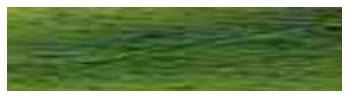

('Actual:', 'ਮੈਤਰਿਆ', 'Prediction:', 'ਮ--ੇਤ---ਰਿ-ਆ-', 'Prediction Corrected:', 'ਮੇਤਰਿਆ')


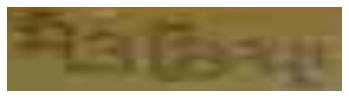

('Actual:', 'ਜਹ', 'Prediction:', 'ਕ----------ਰ-', 'Prediction Corrected:', 'ਕਰ')


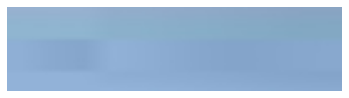

('Actual:', 'ਨਖ਼ਲਿਸਤਾਨ', 'Prediction:', 'ਅ-----ਨਿਸ-ਤਾਲ', 'Prediction Corrected:', 'ਅਨਿਸਤਾਲ')


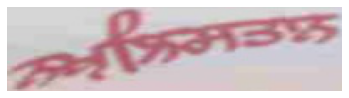

('Actual:', 'ਆਪੇ', 'Prediction:', 'ਆ----------ਪ-', 'Prediction Corrected:', 'ਆਪ')


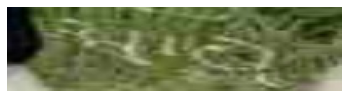

In [33]:
visualize_misclassifications('Test')

('Actual:', 'ਨਸ਼ਟ', 'Prediction:', 'ਨ------ਸ਼---ਟ-', 'Prediction Corrected:', 'ਨਸ਼ਟ')


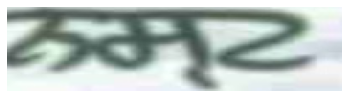

('Actual:', 'ਕਿਲਬਿਖ', 'Prediction:', 'ਕ-ਿਿ-ਲ---ਖਿਖ-', 'Prediction Corrected:', 'ਕਿਲਖਿਖ')


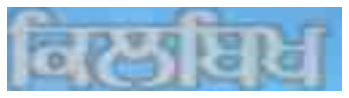

('Actual:', 'ਪਰਮਾਣੂ', 'Prediction:', 'ਪ---ਰ---ਮਾ-ਣੁ', 'Prediction Corrected:', 'ਪਰਮਾਣੁ')


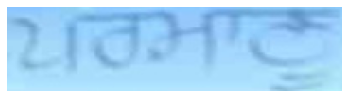

('Actual:', 'ਧੂਲਕੋਟ', 'Prediction:', 'ਯ--ੂ--ਲ--ਕੋਟ-', 'Prediction Corrected:', 'ਯੂਲਕੋਟ')


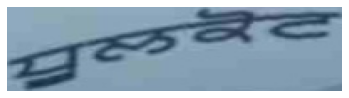

('Actual:', 'ਭਉਜਲੁ', 'Prediction:', 'ਭ----ਉ--ਜ--ਲੂ', 'Prediction Corrected:', 'ਭਉਜਲੂ')


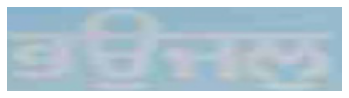

('Actual:', 'ਭੁਵਨ', 'Prediction:', 'ਕ-----ੁ-ਵ--ਨ-', 'Prediction Corrected:', 'ਕੁਵਨ')


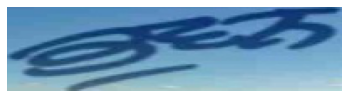

('Actual:', 'ਹੈਰੋਇਨ', 'Prediction:', 'ਹ--ੈਰਰ---ਇ-ਨ-', 'Prediction Corrected:', 'ਹੈਰਇਨ')


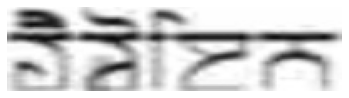

('Actual:', 'ਦਰਸ਼ਨ', 'Prediction:', 'ਦ----ਰ--ਸ਼-ਨ-', 'Prediction Corrected:', 'ਦਰਸ਼ਨ')


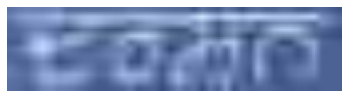

('Actual:', 'ਅਨੁਵਾਦਕ', 'Prediction:', 'ਅ---ਪੁਵਾਾਦ-ਕਕ', 'Prediction Corrected:', 'ਅਪੁਵਾਦਕ')


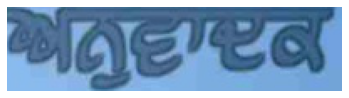

('Actual:', 'ਰੁਦਫੋਰਡ', 'Prediction:', 'ਰ--ੂਦ--ਫੋਰ-ਡਡ', 'Prediction Corrected:', 'ਰੂਦਫੋਰਡ')


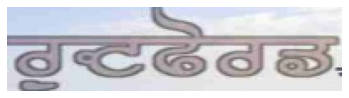

('Actual:', 'ਗਨ', 'Prediction:', 'ਹ----------ਨ-', 'Prediction Corrected:', 'ਹਨ')


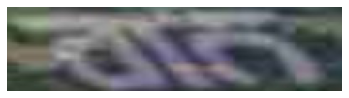

('Actual:', 'ਲਕਸ਼ਮਣਗੜ੍ਹ', 'Prediction:', 'ਲ--ਕਸਸਮਮਣਗੜ੍ਹ', 'Prediction Corrected:', 'ਲਕਸਮਣਗੜ੍ਹ')


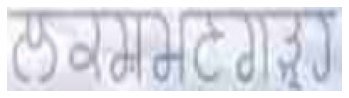

('Actual:', 'ਅਬੈਕਸ', 'Prediction:', 'ਅ----ਰੈ-ਕ--ਸ-', 'Prediction Corrected:', 'ਅਰੈਕਸ')


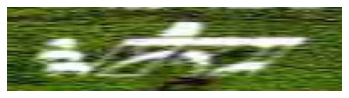

('Actual:', 'ਭਗਵਤ', 'Prediction:', 'ਭ----ਗਾ-ਵ--ਤ-', 'Prediction Corrected:', 'ਭਗਾਵਤ')


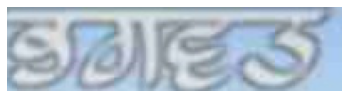

('Actual:', 'ਤਕਦੀਰ', 'Prediction:', 'ਤ----ਕ-ਹਰੀ-ੜ-', 'Prediction Corrected:', 'ਤਕਹਰੀੜ')


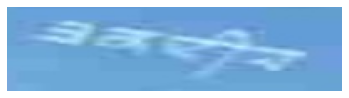

('Actual:', 'ਕਾਲਜ', 'Prediction:', 'ਕ-----ਾਲ---ਕ-', 'Prediction Corrected:', 'ਕਾਲਕ')


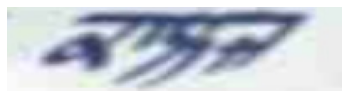

('Actual:', 'ਦਸ਼ਰਥ', 'Prediction:', 'ਦ-----ਸ--ਰ-ਥ-', 'Prediction Corrected:', 'ਦਸਰਥ')


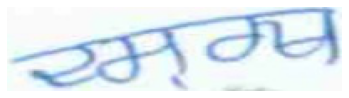

('Actual:', 'ਨਖ਼ਲਿਸਤਾਨ', 'Prediction:', 'ਅ-----ਨਿਸ-ਤਾਲ', 'Prediction Corrected:', 'ਅਨਿਸਤਾਲ')


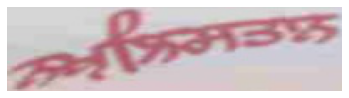

('Actual:', 'ਫੇਰੀ', 'Prediction:', 'ਫ-----ੋ----ਰੀ', 'Prediction Corrected:', 'ਫੋਰੀ')


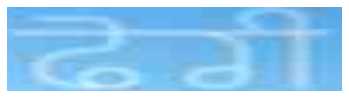

('Actual:', 'ਕਰੂਸ', 'Prediction:', 'ਕ------ਰੂ--ਮ-', 'Prediction Corrected:', 'ਕਰੂਮ')


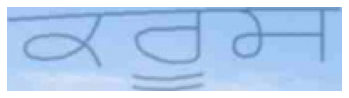

In [34]:
visualize_misclassifications('Test-V2')

### References:
[1] https://github.com/carnotaur/crnn-tutorial/

In [35]:
#stest_result